### The STV-FIS effort is funded by the NASA Decadal Survey Incubation program - **NNH21ZDA001N-DSI**

# SDAP Tomogram Visualization Endpoints

This notebook showcases some work in progress vizualization capabilities built directly into SDAP for the purposes of visuzlizing SAR and LIDAR data. The following demo products were used:
- SAR: Work in progress geolocated product (not publicly availabe). Kings Canyon, CA; Lope Nat'l Park, Gabon (HH, HV, VV); Rabi Forest, Gabon (HH, HV, VV); Redwood Nat'l Park, CA (HH, HV, VV | L- & P-band)
- LIDAR: [This dataset](https://daac.ornl.gov/ABOVE/guides/ABoVE_LVIS_VegetationStructure.html) (ABoVE: LVIS L3 Gridded Vegetation Structure across North America, 2017 and 2019)

LIDAR support is commented out (as of 2024-04-11) as the version of SDAP currently deployed does not support LIDAR, nor is it ingested into said deployment.

**NOTE**

You must be connected to the JPL Network/VPN to run this notebook. 

**ALSO NOTE**

The current configuration of the system has a fairly short timeout (60s), so try making queries fairly small. Refer to the exaples section for queries that should work.

In [95]:
import requests
from io import BytesIO
from PIL import Image
from IPython.display import display
from datetime import datetime
import ipywidgets as widgets
from IPython.display import display
from math import floor, ceil
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

# NOTE: Disabling verification due to certificate issues on my local machine

def get(url, params):
    t = datetime.now()
    
    try:
        print('Waiting for response from SDAP...', end='')
        response = requests.get(url, params=params, verify=False)
        td = datetime.now() - t
        response.raise_for_status()
        
        print(f' Done in {td}')
    except:
        td = datetime.now() - t
        print(f' Failed in {td}')
        print(response.text)
        raise
        
    return response



In [96]:
BASE_URL = 'https://digitaltwin.jpl.nasa.gov'
NEXUS_URL = f'{BASE_URL}/nexus'

# TOMOGRAM_ELEV_URL = f'{NEXUS_URL}/tomogram/elevation'
TOMOGRAM_LAT_URL = f'{NEXUS_URL}/tomogram/latitude'
TOMOGRAM_LON_URL = f'{NEXUS_URL}/tomogram/longitude'

# LIDAR_URL = f'{NEXUS_URL}/stv/lidar'

TOMOGRAM_DS_KC = 'Kings_Canyon_Tomogram'
TOMOGRAM_DS_Lope = 'Lope_Tomogram_{}'
TOMOGRAM_DS_Rabi = 'Rabi_Tomogram_{}'
TOMOGRAM_DS_Redwood_Lband = 'Redwood_Tomogram_L_{}'
TOMOGRAM_DS_Redwood_Pband = 'Redwood_Tomogram_P_{}'
# LIDAR_DS = 'LVIS_ABoVE'



In [97]:
sites = [
    ('Kings Canyon National Park, US', 'kcnp'),
    ('Lope National Park, GA', 'lope'),
    ('Rabi Forest, GA', 'rabi'),
    ('Redwood National Park, US (L-band)', 'redl'),
    ('Redwood National Park, US (P-band)', 'redp'),
]

site_sel = widgets.Dropdown(options=sites, description='Site: ', disabled=False, layout = widgets.Layout(width='350px'))
pol_sel = widgets.Dropdown(options=['HH', 'HV', 'VV'], description='Pol: ', disabled=False, layout = widgets.Layout(width='350px'))
dim_sel = widgets.Dropdown(options=['Latitude', 'Longitude'], description='Direction: ', disabled=False, layout = widgets.Layout(width='350px'))
dem_sel = widgets.Checkbox(value=True, disabled=False, description='Add DEM')
peaks = widgets.Checkbox(value=False, disabled=False, description='Show peaks in plot')


display(site_sel)
display(pol_sel)
display(dim_sel)
display(dem_sel)
display(peaks)

Dropdown(description='Site: ', layout=Layout(width='350px'), options=(('Kings Canyon National Park, US', 'kcnp…

Dropdown(description='Pol: ', layout=Layout(width='350px'), options=('HH', 'HV', 'VV'), value='HH')

Dropdown(description='Direction: ', layout=Layout(width='350px'), options=('Latitude', 'Longitude'), value='La…

Checkbox(value=True, description='Add DEM')

Checkbox(value=False, description='Show peaks in plot')

In [98]:
PARAMS = {
    'kcnp': dict(ds=TOMOGRAM_DS_KC,            bounds=dict(min_lon=-119.60,  max_lon=-118.75,  min_lat=36.98,  max_lat=37.15,  min_elev=66.84,  max_elev=3732.20, min_elev_nd=-60,  max_elev_nd=60), stride=1, elevationMargin=0.5),
    'lope': dict(ds=TOMOGRAM_DS_Lope,          bounds=dict(min_lon=11.43,    max_lon=11.83,    min_lat=-0.34,  max_lat=0.07,   min_elev=2.5,    max_elev=717.87,  min_elev_nd=-102, max_elev_nd=56), stride=2, elevationMargin=1),
    'rabi': dict(ds=TOMOGRAM_DS_Rabi,          bounds=dict(min_lon=9.70,     max_lon=10.11,    min_lat=-2.05,  max_lat=-1.65,  min_elev=-94.90, max_elev=236.65,  min_elev_nd=-102, max_elev_nd=56), stride=2, elevationMargin=1),
    'redl': dict(ds=TOMOGRAM_DS_Redwood_Lband, bounds=dict(min_lon=-124.247, max_lon=-123.903, min_lat=41.571, max_lat=41.888, min_elev=-89.13, max_elev=1147.06, min_elev_nd=-60,  max_elev_nd=60), stride=1, elevationMargin=0.5),
    'redp': dict(ds=TOMOGRAM_DS_Redwood_Pband, bounds=dict(min_lon=-124.247, max_lon=-123.896, min_lat=41.528, max_lat=41.888, min_elev=-89.22, max_elev=1146.80, min_elev_nd=-60,  max_elev_nd=60), stride=1, elevationMargin=0.5),
}

params = PARAMS[site_sel.value]

if site_sel.value != 'kcnp':
    params['ds'] = params['ds'].format(pol_sel.value)
    
if not dem_sel.value:
    params['ds'] = params['ds'] + '_NO_DEM'
    params['bounds']['min_elev'] = params['bounds']['min_elev_nd']
    params['bounds']['max_elev'] = params['bounds']['max_elev_nd']

del params['bounds']['min_elev_nd']
del params['bounds']['max_elev_nd']

s = widgets.FloatSlider(
    value=((params['bounds']['min_lon'] + params['bounds']['max_lon']) / 2) if dim_sel.value == 'Longitude' else ((params['bounds']['min_lat'] + params['bounds']['max_lat']) / 2),
    min=params['bounds']['min_lon'] if dim_sel.value == 'Longitude' else params['bounds']['min_lat'],
    max=params['bounds']['max_lon'] if dim_sel.value == 'Longitude' else params['bounds']['max_lat'],
    step=0.001,
    description=f'{dim_sel.value}: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
    layout = widgets.Layout(width='500px')
)

d = widgets.FloatRangeSlider(
    value=[
        params['bounds']['min_lat'] if dim_sel.value == 'Longitude' else params['bounds']['min_lon'],
        params['bounds']['max_lat'] if dim_sel.value == 'Longitude' else params['bounds']['max_lon']
    ],
    min=params['bounds']['min_lat'] if dim_sel.value == 'Longitude' else params['bounds']['min_lon'],
    max=params['bounds']['max_lat'] if dim_sel.value == 'Longitude' else params['bounds']['max_lon'],
    step=0.01,
    description='Latitude: ' if dim_sel.value == 'Longitude' else 'Longitude: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
    layout = widgets.Layout(width='500px')
)

e = widgets.IntRangeSlider(
    value=[params['bounds']['min_elev'], params['bounds']['max_elev']],
    min=floor(params['bounds']['min_elev']),
    max=ceil(params['bounds']['max_elev']),
    step=1,
    description='Elevation: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout = widgets.Layout(width='500px')
)

display(s)
display(d)
display(e)

FloatSlider(value=37.065, continuous_update=False, description='Latitude: ', layout=Layout(width='500px'), max…

FloatRangeSlider(value=(-119.6, -118.75), continuous_update=False, description='Longitude: ', layout=Layout(wi…

IntRangeSlider(value=(-60, 60), continuous_update=False, description='Elevation: ', layout=Layout(width='500px…

Waiting for response from SDAP... Done in 0:00:09.889135


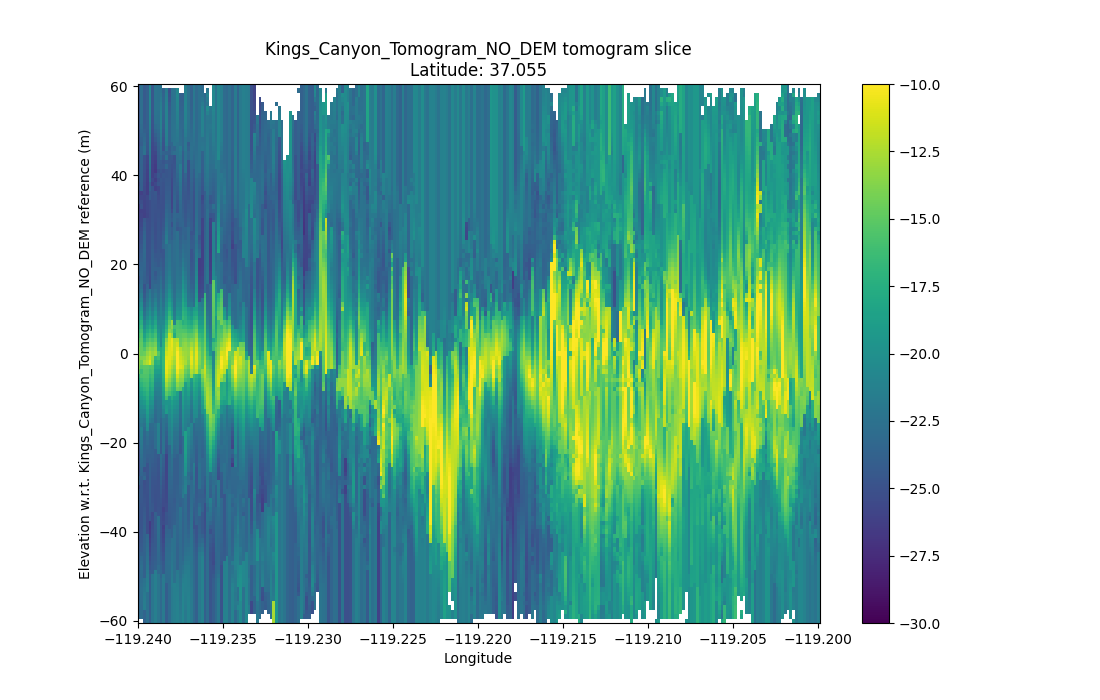

In [100]:
if dim_sel.value == 'Longitude':
    params['longitude'] = s.value
    (params['minLat'], params['maxLat']) = d.value
    url = TOMOGRAM_LON_URL
else:
    params['latitude'] = s.value
    (params['minLon'], params['maxLon']) = d.value
    url = TOMOGRAM_LAT_URL
    
(params['minElevation'], params['maxElevation']) = e.value
params['output'] = 'PNG'
params['peaks'] = peaks.value

response = get(url, {p: params[p] for p in params if p != 'bounds'})

buf = BytesIO(response.content)

img = Image.open(buf)
display(img)

## Examples

Waiting for response from SDAP... Done in 0:00:24.781561


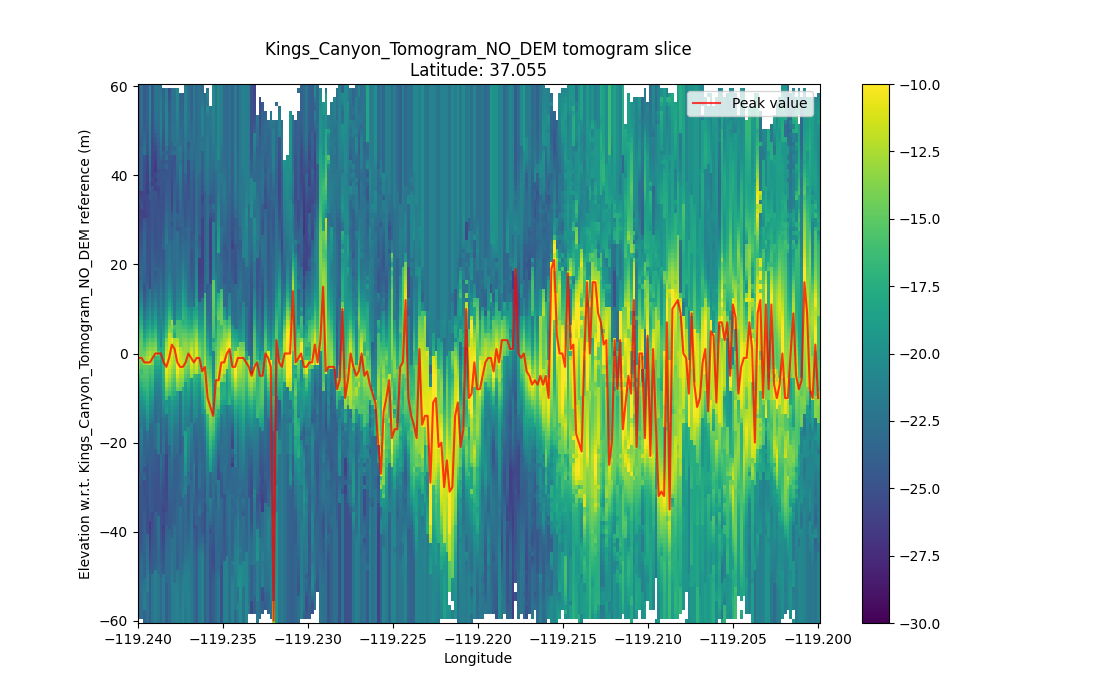

In [13]:
params = dict(
    ds=TOMOGRAM_DS_KC + '_NO_DEM',
    output='PNG',
    latitude=37.055,
    minLon=-119.24,
    maxLon=-119.2,
    minElevation=-121,
    maxElevation=121,
    stride=1,
    peaks=True
)

response = get(TOMOGRAM_LAT_URL, params)

buf = BytesIO(response.content)

img = Image.open(buf)
display(img)

Waiting for response from SDAP... Done in 0:00:32.079661


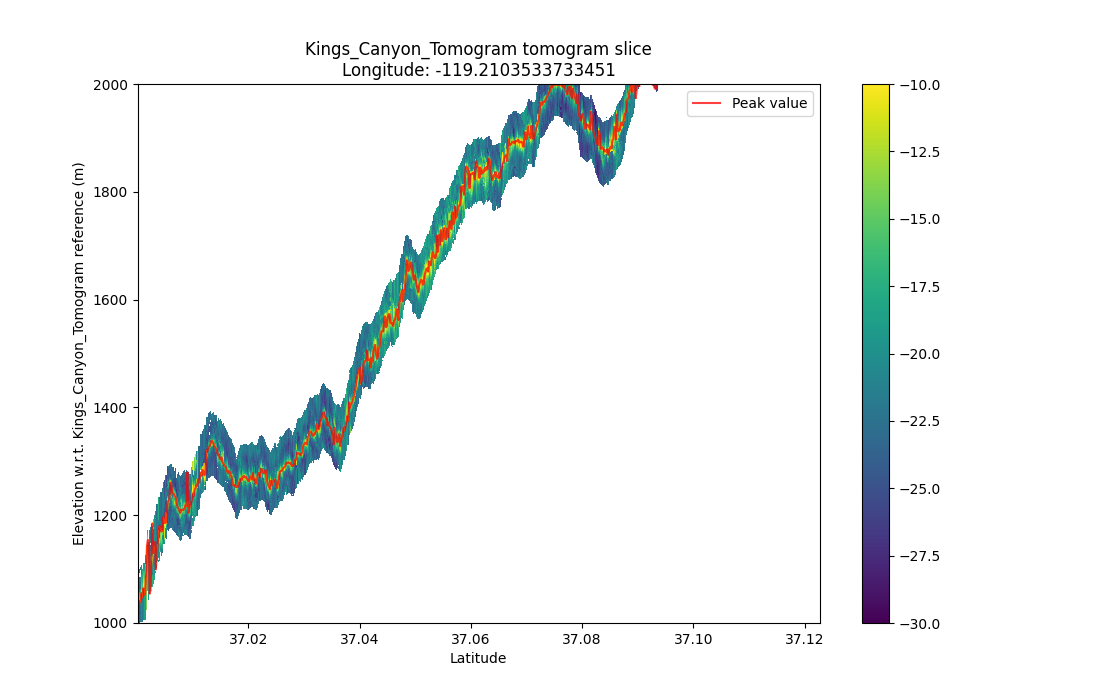

In [15]:
params = dict(
    ds=TOMOGRAM_DS_KC,
    output='PNG',
    longitude=-119.2103533733451,
    minLat=37,
    maxLat=37.25,
    minElevation=1000,
    maxElevation=2000,
    stride=1,
    peaks=True
)

response = get(TOMOGRAM_LON_URL, params)

buf = BytesIO(response.content)

img = Image.open(buf)
display(img)

Waiting for response from SDAP... Done in 0:00:05.258988


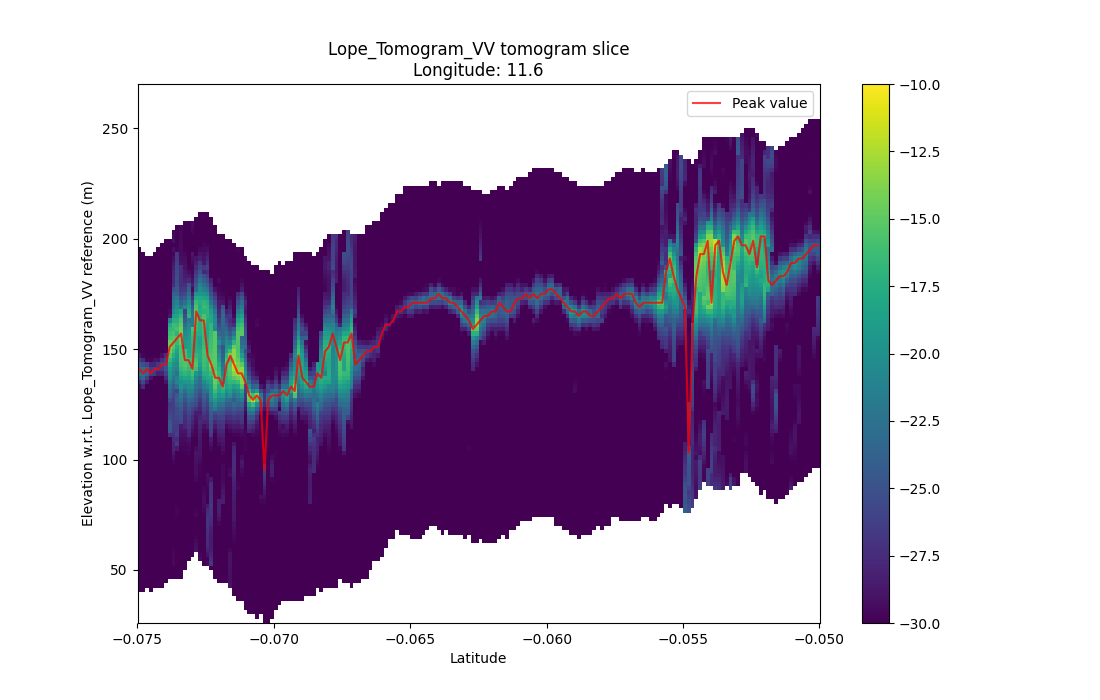

In [18]:
params = dict(
    ds=TOMOGRAM_DS_Lope.format('VV'),
    output='PNG',
    longitude=11.6,
    minLat=-0.075,
    maxLat=-0.05,
    minElevation=5,
    maxElevation=350,
    stride=2, elevationMargin=1,
    peaks=True
)

response = get(TOMOGRAM_LON_URL, params)

buf = BytesIO(response.content)

img = Image.open(buf)
display(img)

Waiting for response from SDAP... Done in 0:00:33.896046


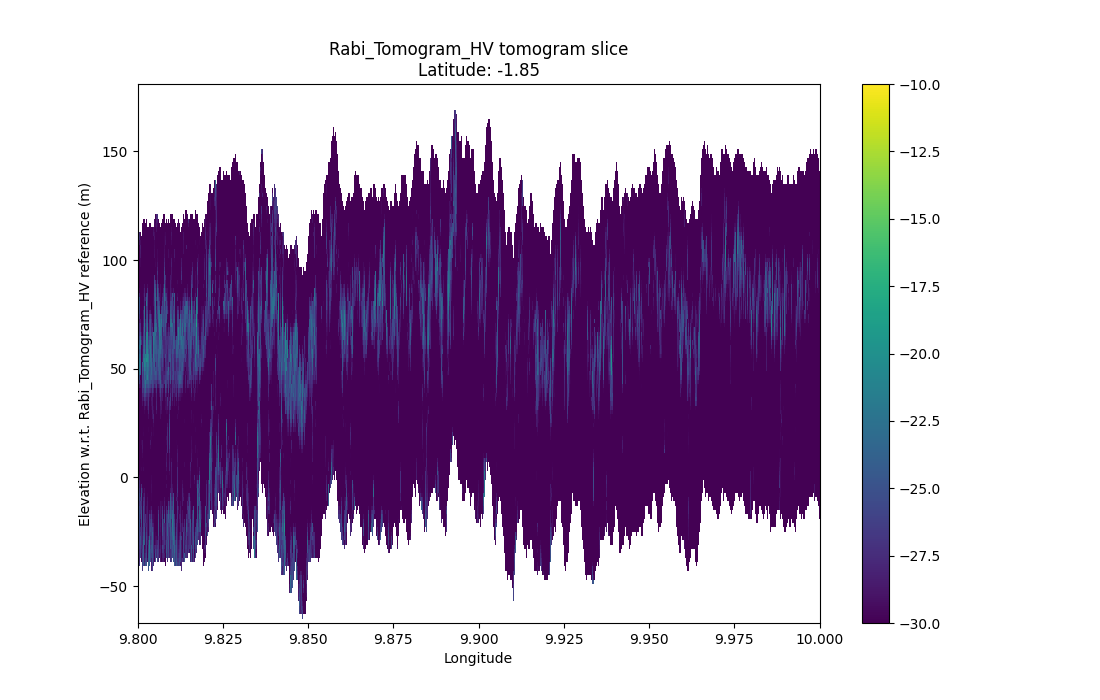

In [22]:
params = dict(
    ds=TOMOGRAM_DS_Rabi.format('HV'),
    output='PNG',
    latitude=-1.85,
    minLon=9.8,
    maxLon=10,
    minElevation=-90,
    maxElevation=1200,
    stride=2, elevationMargin=1,
    peaks=False
)

response = get(TOMOGRAM_LAT_URL, params)

buf = BytesIO(response.content)

img = Image.open(buf)
display(img)

## LIDAR - [DO NOT RUN THESE CELLS]

The following cells will showcase SDAP's LIDAR endpoint (Still a WIP)

In [ ]:
# Following params will just produce 2D plots of vegetation heights, terrain height, and canopy coverage

# params = dict(
#     ds='LVIS_ABoVE',
#     b='-107.5,52.5,-106.5,53',
#     startTime='2017-06-29T00:00:00Z',
#     endTime='2017-06-29T00:00:00Z',
#     output='PNG'
# )

# response = get(LIDAR_URL, params)

# buf = BytesIO(response.content)

# img = Image.open(buf)
# display(img)

In [ ]:
# Easily add 1D plots showing the values along a given latitude...

# params = dict(
#     ds='LVIS_ABoVE',
#     b='-107.5,52.5,-106.5,53',
#     startTime='2017-06-29T00:00:00Z',
#     endTime='2017-06-29T00:00:00Z',
#     latSlice=52.95,
#     output='PNG'
# )

# response = get(LIDAR_URL, params)

# buf = BytesIO(response.content)

# img = Image.open(buf)
# display(img)

In [ ]:
# ... or longitude ...

# params = dict(
#     ds='LVIS_ABoVE',
#     b='-107.5,52.5,-106.5,53',
#     startTime='2017-06-29T00:00:00Z',
#     endTime='2017-06-29T00:00:00Z',
#     lonSlice=-107.12,
#     output='PNG'
# )

# response = get(LIDAR_URL, params)

# buf = BytesIO(response.content)

# img = Image.open(buf)
# display(img)

In [ ]:
# ... or both at the same time!

# params = dict(
#     ds='LVIS_ABoVE',
#     b='-107.5,52.5,-106.5,53',
#     startTime='2017-06-29T00:00:00Z',
#     endTime='2017-06-29T00:00:00Z',
#     latSlice=52.95,
#     lonSlice=-107.12,
#     output='PNG'
# )

# response = get(LIDAR_URL, params)

# buf = BytesIO(response.content)

# img = Image.open(buf)
# display(img)